# Step -1

## Requirement is to take MNIST data and achieve the below targets -

- Reach 99.4% accuracy(this must be consistent in last few epochs and not a one-time achievement)
- Use less than or equal to 15 Epochs
- Use less than 10000 Parameters

## The approach has been divided into 5 steps. This note book has the first part and includes the following -

### Step - 1 
- Cleaning the base version of the network 
- Reducing the parameters
- Training, Testing and Analyzing
- Making the network ready for further tuning

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

## Data Transformations

We first start with defining our basic data transformations. Depending on the results we will add necessary transformations at a later stage. 

Following transformations have been done as a part of Step -1

1.   ToTensor conversion
2.   Normalize using mean and std of the entire MNST dataset - ((0.1307,), (0.3081,)) respectively.

In [ ]:
# Finding the mean and standard deviation values fro MNIST dataset
simple_transforms = transforms.Compose([
                                      transforms.ToTensor()
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Tensor Shape:', exp.train_data.size())
print(' - Min:', torch.min(exp_data))
print(' - Max:', torch.max(exp_data))
print(' - Mean:', torch.mean(exp_data))
print(' - Std:', torch.std(exp_data))
print(' - Var:', torch.var(exp_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Min: tensor(0.)
 - Max: tensor(1.)
 - Mean: tensor(0.1307)
 - Std: tensor(0.3081)
 - Var: tensor(0.0949)


# Building transformation rules for our dataset

In [ ]:
# Using the mean and standard deviation values to normalize the dataset.
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std for MNIST dataset
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])


# Dataset and Creating Train/Test Split with transformation rules.

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

Checking some of the statistics around our data.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Min: tensor(-0.4242)
 - Max: tensor(2.8215)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


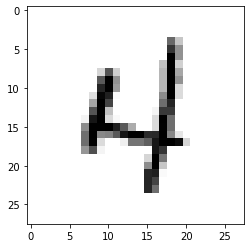

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Min:', torch.min(train_data))
print(' - Max:', torch.max(train_data))
# The data has already been transformed using Mean and Standard deviation. 
# Going for a mean and standard deviation again would give us zeros and ones.
#print(' - Mean:', torch.mean(train_data)) 
#print(' - Std:', torch.std(train_data))
#print(' - Var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

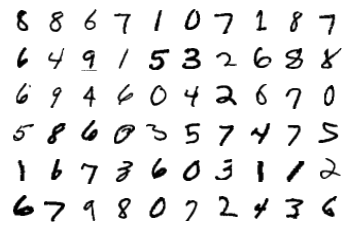

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The base version of the model
We start with the base model we have. This has been later cleaned up for a better readability and ease of debugging.

In [ ]:
# This is the base version of the network, difficult to read and very heavy with parameters.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #Output RF 3X3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Base Model Parameters as below

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# Rebuilding the network again with a better readability and with fewer parameters.
# The out channels have been set in accordance with raising to the power 2 for a better GPU utilization.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Parameters of our new model as below

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
            Conv2d-3           [-1, 12, 24, 24]           1,296
              ReLU-4           [-1, 12, 24, 24]               0
            Conv2d-5           [-1, 24, 22, 22]           2,592
              ReLU-6           [-1, 24, 22, 22]               0
         MaxPool2d-7           [-1, 24, 11, 11]               0
            Conv2d-8           [-1, 12, 11, 11]             288
              ReLU-9           [-1, 12, 11, 11]               0
           Conv2d-10             [-1, 12, 9, 9]           1,296
             ReLU-11             [-1, 12, 9, 9]               0
           Conv2d-12             [-1, 24, 7, 7]           2,592
             ReLU-13             [-1, 24, 7, 7]               0
           Conv2d-14             [-1, 1

# Observation

We still have more than 10000 parameters which needs to be reduced to less than 10000. This will be reduced in the Part 2 of tuning process.
We will check the performance of the network with current structure.

Also, we have introduce **tqdm** progressbar to get a more presentable logs. 

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Hence we are setting the graident to zero at the start of each loop so that the parameters update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.18857134878635406 Batch_id=468 Accuracy=51.65: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.1969, Accuracy: 9381/10000 (93.81%)

EPOCH: 1


Loss=0.11538634449243546 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]



Test set: Average loss: 0.0899, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.05657176300883293 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0696, Accuracy: 9783/10000 (97.83%)

EPOCH: 3


Loss=0.04489217698574066 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]



Test set: Average loss: 0.0655, Accuracy: 9786/10000 (97.86%)

EPOCH: 4


Loss=0.05831537023186684 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]



Test set: Average loss: 0.0638, Accuracy: 9798/10000 (97.98%)

EPOCH: 5


Loss=0.01918848603963852 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.0527, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.04176594316959381 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]



Test set: Average loss: 0.0560, Accuracy: 9824/10000 (98.24%)

EPOCH: 7


Loss=0.018166372552514076 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0521, Accuracy: 9832/10000 (98.32%)

EPOCH: 8


Loss=0.004712516441941261 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]



Test set: Average loss: 0.0518, Accuracy: 9832/10000 (98.32%)

EPOCH: 9


Loss=0.07214398682117462 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0480, Accuracy: 9855/10000 (98.55%)

EPOCH: 10


Loss=0.03542511537671089 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]



Test set: Average loss: 0.0503, Accuracy: 9845/10000 (98.45%)

EPOCH: 11


Loss=0.054435845464468 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0490, Accuracy: 9852/10000 (98.52%)

EPOCH: 12


Loss=0.006930250208824873 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0471, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.13777141273021698 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]



Test set: Average loss: 0.0439, Accuracy: 9866/10000 (98.66%)

EPOCH: 14


Loss=0.01215225551277399 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]



Test set: Average loss: 0.0434, Accuracy: 9870/10000 (98.70%)



Text(0.5, 1.0, 'Test Accuracy')

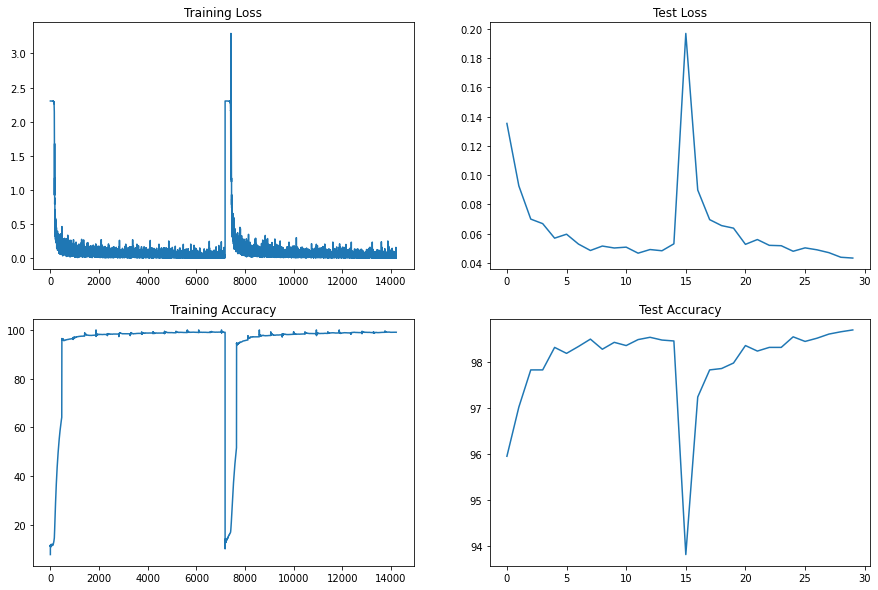

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Inference:
- The model is still large but working. 
- We see some over-fitting.
- Accuracy needs improvement.
